# Convolutional Neural Network  - Transfer Learning

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

Feedbackte istendiği gibi Early Stop eklendi, test ve validation setleri ayrıştırıldı.

In [10]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [11]:
train_dir = "./dataset/Training"
val_dir = "./dataset/Validation"
input_size = (224, 224)
batch_size = 64

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=transform['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=transform['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [16]:
# Load Model
model = models.vgg16(pretrained=True)

# Freeze Layers
for param in model.parameters():
    param.requires_grad = False

# Custom Classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.1), # Dropout is applied with probability 0.1 to prevent overfitting
    nn.Linear(256, 2)  # Output is 2 dimensional (male and female)
)

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.013) # Adam Optimizer

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

## Training

In [17]:
best_val_loss = np.inf
patience = 3
counter = 0

In [18]:
num_epochs = 10
for epoch in range(num_epochs):
    
    if counter >= patience:
        print(f"Early stopping in iteration {counter} -->> no improvement in validation loss.")
        break
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total_batches = len(dataloaders[phase])

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            #all_preds.extend(preds.cpu().numpy())
            #all_labels.extend(labels.cpu().numpy())
            
            batch_loss = loss.item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Phase: {phase}, Batch: [{batch_idx+1}/{total_batches}], Loss: {batch_loss:.4f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        scheduler.step()

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            counter = 0
        elif phase == 'val':
            counter += 1

Epoch [1/10], Phase: train, Batch: [1/730], Loss: 0.7110
Epoch [1/10], Phase: train, Batch: [2/730], Loss: 5.2324
Epoch [1/10], Phase: train, Batch: [3/730], Loss: 8.0156
Epoch [1/10], Phase: train, Batch: [4/730], Loss: 5.5205
Epoch [1/10], Phase: train, Batch: [5/730], Loss: 1.7592
Epoch [1/10], Phase: train, Batch: [6/730], Loss: 0.5470
Epoch [1/10], Phase: train, Batch: [7/730], Loss: 1.2411
Epoch [1/10], Phase: train, Batch: [8/730], Loss: 1.2298
Epoch [1/10], Phase: train, Batch: [9/730], Loss: 0.7053
Epoch [1/10], Phase: train, Batch: [10/730], Loss: 0.4364
Epoch [1/10], Phase: train, Batch: [11/730], Loss: 0.4962
Epoch [1/10], Phase: train, Batch: [12/730], Loss: 0.7222
Epoch [1/10], Phase: train, Batch: [13/730], Loss: 0.4847
Epoch [1/10], Phase: train, Batch: [14/730], Loss: 0.4511
Epoch [1/10], Phase: train, Batch: [15/730], Loss: 0.4752
Epoch [1/10], Phase: train, Batch: [16/730], Loss: 0.3779
Epoch [1/10], Phase: train, Batch: [17/730], Loss: 0.4946
Epoch [1/10], Phase: tr

Epoch [1/10], Phase: train, Batch: [142/730], Loss: 0.2933
Epoch [1/10], Phase: train, Batch: [143/730], Loss: 0.5004
Epoch [1/10], Phase: train, Batch: [144/730], Loss: 0.3234
Epoch [1/10], Phase: train, Batch: [145/730], Loss: 0.4183
Epoch [1/10], Phase: train, Batch: [146/730], Loss: 0.2712
Epoch [1/10], Phase: train, Batch: [147/730], Loss: 0.3539
Epoch [1/10], Phase: train, Batch: [148/730], Loss: 0.2665
Epoch [1/10], Phase: train, Batch: [149/730], Loss: 0.3361
Epoch [1/10], Phase: train, Batch: [150/730], Loss: 0.3718
Epoch [1/10], Phase: train, Batch: [151/730], Loss: 0.3671
Epoch [1/10], Phase: train, Batch: [152/730], Loss: 0.2318
Epoch [1/10], Phase: train, Batch: [153/730], Loss: 0.3167
Epoch [1/10], Phase: train, Batch: [154/730], Loss: 0.3238
Epoch [1/10], Phase: train, Batch: [155/730], Loss: 0.3697
Epoch [1/10], Phase: train, Batch: [156/730], Loss: 0.3073
Epoch [1/10], Phase: train, Batch: [157/730], Loss: 0.4686
Epoch [1/10], Phase: train, Batch: [158/730], Loss: 0.23

Epoch [1/10], Phase: train, Batch: [281/730], Loss: 0.3055
Epoch [1/10], Phase: train, Batch: [282/730], Loss: 0.2513
Epoch [1/10], Phase: train, Batch: [283/730], Loss: 0.3411
Epoch [1/10], Phase: train, Batch: [284/730], Loss: 0.3897
Epoch [1/10], Phase: train, Batch: [285/730], Loss: 0.3201
Epoch [1/10], Phase: train, Batch: [286/730], Loss: 0.3669
Epoch [1/10], Phase: train, Batch: [287/730], Loss: 0.2959
Epoch [1/10], Phase: train, Batch: [288/730], Loss: 0.3005
Epoch [1/10], Phase: train, Batch: [289/730], Loss: 0.2622
Epoch [1/10], Phase: train, Batch: [290/730], Loss: 0.2837
Epoch [1/10], Phase: train, Batch: [291/730], Loss: 0.2515
Epoch [1/10], Phase: train, Batch: [292/730], Loss: 0.2416
Epoch [1/10], Phase: train, Batch: [293/730], Loss: 0.4275
Epoch [1/10], Phase: train, Batch: [294/730], Loss: 0.4316
Epoch [1/10], Phase: train, Batch: [295/730], Loss: 0.3200
Epoch [1/10], Phase: train, Batch: [296/730], Loss: 0.1920
Epoch [1/10], Phase: train, Batch: [297/730], Loss: 0.16

Epoch [1/10], Phase: train, Batch: [420/730], Loss: 0.2391
Epoch [1/10], Phase: train, Batch: [421/730], Loss: 0.3953
Epoch [1/10], Phase: train, Batch: [422/730], Loss: 0.3747
Epoch [1/10], Phase: train, Batch: [423/730], Loss: 0.3283
Epoch [1/10], Phase: train, Batch: [424/730], Loss: 0.4155
Epoch [1/10], Phase: train, Batch: [425/730], Loss: 0.3211
Epoch [1/10], Phase: train, Batch: [426/730], Loss: 0.2668
Epoch [1/10], Phase: train, Batch: [427/730], Loss: 0.3090
Epoch [1/10], Phase: train, Batch: [428/730], Loss: 0.3110
Epoch [1/10], Phase: train, Batch: [429/730], Loss: 0.2895
Epoch [1/10], Phase: train, Batch: [430/730], Loss: 0.3682
Epoch [1/10], Phase: train, Batch: [431/730], Loss: 0.3563
Epoch [1/10], Phase: train, Batch: [432/730], Loss: 0.3515
Epoch [1/10], Phase: train, Batch: [433/730], Loss: 0.2550
Epoch [1/10], Phase: train, Batch: [434/730], Loss: 0.2529
Epoch [1/10], Phase: train, Batch: [435/730], Loss: 0.1899
Epoch [1/10], Phase: train, Batch: [436/730], Loss: 0.30

Epoch [1/10], Phase: train, Batch: [559/730], Loss: 0.5140
Epoch [1/10], Phase: train, Batch: [560/730], Loss: 0.3045
Epoch [1/10], Phase: train, Batch: [561/730], Loss: 0.2818
Epoch [1/10], Phase: train, Batch: [562/730], Loss: 0.3503
Epoch [1/10], Phase: train, Batch: [563/730], Loss: 0.2821
Epoch [1/10], Phase: train, Batch: [564/730], Loss: 0.3475
Epoch [1/10], Phase: train, Batch: [565/730], Loss: 0.3204
Epoch [1/10], Phase: train, Batch: [566/730], Loss: 0.3054
Epoch [1/10], Phase: train, Batch: [567/730], Loss: 0.3545
Epoch [1/10], Phase: train, Batch: [568/730], Loss: 0.2517
Epoch [1/10], Phase: train, Batch: [569/730], Loss: 0.2283
Epoch [1/10], Phase: train, Batch: [570/730], Loss: 0.3802
Epoch [1/10], Phase: train, Batch: [571/730], Loss: 0.3236
Epoch [1/10], Phase: train, Batch: [572/730], Loss: 0.4419
Epoch [1/10], Phase: train, Batch: [573/730], Loss: 0.3262
Epoch [1/10], Phase: train, Batch: [574/730], Loss: 0.1885
Epoch [1/10], Phase: train, Batch: [575/730], Loss: 0.48

Epoch [1/10], Phase: train, Batch: [698/730], Loss: 0.2925
Epoch [1/10], Phase: train, Batch: [699/730], Loss: 0.3348
Epoch [1/10], Phase: train, Batch: [700/730], Loss: 0.2907
Epoch [1/10], Phase: train, Batch: [701/730], Loss: 0.2350
Epoch [1/10], Phase: train, Batch: [702/730], Loss: 0.2687
Epoch [1/10], Phase: train, Batch: [703/730], Loss: 0.4053
Epoch [1/10], Phase: train, Batch: [704/730], Loss: 0.2356
Epoch [1/10], Phase: train, Batch: [705/730], Loss: 0.3696
Epoch [1/10], Phase: train, Batch: [706/730], Loss: 0.3326
Epoch [1/10], Phase: train, Batch: [707/730], Loss: 0.2746
Epoch [1/10], Phase: train, Batch: [708/730], Loss: 0.2734
Epoch [1/10], Phase: train, Batch: [709/730], Loss: 0.3025
Epoch [1/10], Phase: train, Batch: [710/730], Loss: 0.2691
Epoch [1/10], Phase: train, Batch: [711/730], Loss: 0.4075
Epoch [1/10], Phase: train, Batch: [712/730], Loss: 0.3785
Epoch [1/10], Phase: train, Batch: [713/730], Loss: 0.3561
Epoch [1/10], Phase: train, Batch: [714/730], Loss: 0.27

Epoch [1/10], Phase: val, Batch: [112/182], Loss: 0.1516
Epoch [1/10], Phase: val, Batch: [113/182], Loss: 0.1226
Epoch [1/10], Phase: val, Batch: [114/182], Loss: 0.2214
Epoch [1/10], Phase: val, Batch: [115/182], Loss: 0.1521
Epoch [1/10], Phase: val, Batch: [116/182], Loss: 0.2291
Epoch [1/10], Phase: val, Batch: [117/182], Loss: 0.1282
Epoch [1/10], Phase: val, Batch: [118/182], Loss: 0.1964
Epoch [1/10], Phase: val, Batch: [119/182], Loss: 0.1453
Epoch [1/10], Phase: val, Batch: [120/182], Loss: 0.1580
Epoch [1/10], Phase: val, Batch: [121/182], Loss: 0.1841
Epoch [1/10], Phase: val, Batch: [122/182], Loss: 0.1660
Epoch [1/10], Phase: val, Batch: [123/182], Loss: 0.2314
Epoch [1/10], Phase: val, Batch: [124/182], Loss: 0.1335
Epoch [1/10], Phase: val, Batch: [125/182], Loss: 0.1448
Epoch [1/10], Phase: val, Batch: [126/182], Loss: 0.1714
Epoch [1/10], Phase: val, Batch: [127/182], Loss: 0.1580
Epoch [1/10], Phase: val, Batch: [128/182], Loss: 0.1584
Epoch [1/10], Phase: val, Batch

Epoch [2/10], Phase: train, Batch: [73/730], Loss: 0.3303
Epoch [2/10], Phase: train, Batch: [74/730], Loss: 0.2035
Epoch [2/10], Phase: train, Batch: [75/730], Loss: 0.4771
Epoch [2/10], Phase: train, Batch: [76/730], Loss: 0.2352
Epoch [2/10], Phase: train, Batch: [77/730], Loss: 0.2178
Epoch [2/10], Phase: train, Batch: [78/730], Loss: 0.1695
Epoch [2/10], Phase: train, Batch: [79/730], Loss: 0.2125
Epoch [2/10], Phase: train, Batch: [80/730], Loss: 0.2611
Epoch [2/10], Phase: train, Batch: [81/730], Loss: 0.3452
Epoch [2/10], Phase: train, Batch: [82/730], Loss: 0.3498
Epoch [2/10], Phase: train, Batch: [83/730], Loss: 0.3810
Epoch [2/10], Phase: train, Batch: [84/730], Loss: 0.3352
Epoch [2/10], Phase: train, Batch: [85/730], Loss: 0.3044
Epoch [2/10], Phase: train, Batch: [86/730], Loss: 0.2939
Epoch [2/10], Phase: train, Batch: [87/730], Loss: 0.2888
Epoch [2/10], Phase: train, Batch: [88/730], Loss: 0.4062
Epoch [2/10], Phase: train, Batch: [89/730], Loss: 0.3132
Epoch [2/10], 

Epoch [2/10], Phase: train, Batch: [213/730], Loss: 0.3936
Epoch [2/10], Phase: train, Batch: [214/730], Loss: 0.2253
Epoch [2/10], Phase: train, Batch: [215/730], Loss: 0.3252
Epoch [2/10], Phase: train, Batch: [216/730], Loss: 0.2047
Epoch [2/10], Phase: train, Batch: [217/730], Loss: 0.3219
Epoch [2/10], Phase: train, Batch: [218/730], Loss: 0.2601
Epoch [2/10], Phase: train, Batch: [219/730], Loss: 0.2114
Epoch [2/10], Phase: train, Batch: [220/730], Loss: 0.3591
Epoch [2/10], Phase: train, Batch: [221/730], Loss: 0.4455
Epoch [2/10], Phase: train, Batch: [222/730], Loss: 0.2127
Epoch [2/10], Phase: train, Batch: [223/730], Loss: 0.3918
Epoch [2/10], Phase: train, Batch: [224/730], Loss: 0.2300
Epoch [2/10], Phase: train, Batch: [225/730], Loss: 0.1775
Epoch [2/10], Phase: train, Batch: [226/730], Loss: 0.2597
Epoch [2/10], Phase: train, Batch: [227/730], Loss: 0.3903
Epoch [2/10], Phase: train, Batch: [228/730], Loss: 0.3718
Epoch [2/10], Phase: train, Batch: [229/730], Loss: 0.36

Epoch [2/10], Phase: train, Batch: [352/730], Loss: 0.2940
Epoch [2/10], Phase: train, Batch: [353/730], Loss: 0.3496
Epoch [2/10], Phase: train, Batch: [354/730], Loss: 0.3710
Epoch [2/10], Phase: train, Batch: [355/730], Loss: 0.2761
Epoch [2/10], Phase: train, Batch: [356/730], Loss: 0.3418
Epoch [2/10], Phase: train, Batch: [357/730], Loss: 0.3185
Epoch [2/10], Phase: train, Batch: [358/730], Loss: 0.2890
Epoch [2/10], Phase: train, Batch: [359/730], Loss: 0.3678
Epoch [2/10], Phase: train, Batch: [360/730], Loss: 0.3365
Epoch [2/10], Phase: train, Batch: [361/730], Loss: 0.4243
Epoch [2/10], Phase: train, Batch: [362/730], Loss: 0.3436
Epoch [2/10], Phase: train, Batch: [363/730], Loss: 0.2100
Epoch [2/10], Phase: train, Batch: [364/730], Loss: 0.3321
Epoch [2/10], Phase: train, Batch: [365/730], Loss: 0.2566
Epoch [2/10], Phase: train, Batch: [366/730], Loss: 0.2906
Epoch [2/10], Phase: train, Batch: [367/730], Loss: 0.3585
Epoch [2/10], Phase: train, Batch: [368/730], Loss: 0.28

Epoch [2/10], Phase: train, Batch: [491/730], Loss: 0.2852
Epoch [2/10], Phase: train, Batch: [492/730], Loss: 0.3350
Epoch [2/10], Phase: train, Batch: [493/730], Loss: 0.2964
Epoch [2/10], Phase: train, Batch: [494/730], Loss: 0.4191
Epoch [2/10], Phase: train, Batch: [495/730], Loss: 0.2316
Epoch [2/10], Phase: train, Batch: [496/730], Loss: 0.3250
Epoch [2/10], Phase: train, Batch: [497/730], Loss: 0.3995
Epoch [2/10], Phase: train, Batch: [498/730], Loss: 0.1948
Epoch [2/10], Phase: train, Batch: [499/730], Loss: 0.3476
Epoch [2/10], Phase: train, Batch: [500/730], Loss: 0.2959
Epoch [2/10], Phase: train, Batch: [501/730], Loss: 0.4412
Epoch [2/10], Phase: train, Batch: [502/730], Loss: 0.2831
Epoch [2/10], Phase: train, Batch: [503/730], Loss: 0.2724
Epoch [2/10], Phase: train, Batch: [504/730], Loss: 0.2211
Epoch [2/10], Phase: train, Batch: [505/730], Loss: 0.2000
Epoch [2/10], Phase: train, Batch: [506/730], Loss: 0.3793
Epoch [2/10], Phase: train, Batch: [507/730], Loss: 0.22

Epoch [2/10], Phase: train, Batch: [630/730], Loss: 0.2464
Epoch [2/10], Phase: train, Batch: [631/730], Loss: 0.3620
Epoch [2/10], Phase: train, Batch: [632/730], Loss: 0.4612
Epoch [2/10], Phase: train, Batch: [633/730], Loss: 0.2417
Epoch [2/10], Phase: train, Batch: [634/730], Loss: 0.2460
Epoch [2/10], Phase: train, Batch: [635/730], Loss: 0.3605
Epoch [2/10], Phase: train, Batch: [636/730], Loss: 0.3161
Epoch [2/10], Phase: train, Batch: [637/730], Loss: 0.3385
Epoch [2/10], Phase: train, Batch: [638/730], Loss: 0.3303
Epoch [2/10], Phase: train, Batch: [639/730], Loss: 0.2149
Epoch [2/10], Phase: train, Batch: [640/730], Loss: 0.4235
Epoch [2/10], Phase: train, Batch: [641/730], Loss: 0.4120
Epoch [2/10], Phase: train, Batch: [642/730], Loss: 0.3231
Epoch [2/10], Phase: train, Batch: [643/730], Loss: 0.2498
Epoch [2/10], Phase: train, Batch: [644/730], Loss: 0.3512
Epoch [2/10], Phase: train, Batch: [645/730], Loss: 0.4212
Epoch [2/10], Phase: train, Batch: [646/730], Loss: 0.30

Epoch [2/10], Phase: val, Batch: [41/182], Loss: 0.2137
Epoch [2/10], Phase: val, Batch: [42/182], Loss: 0.2621
Epoch [2/10], Phase: val, Batch: [43/182], Loss: 0.1876
Epoch [2/10], Phase: val, Batch: [44/182], Loss: 0.2998
Epoch [2/10], Phase: val, Batch: [45/182], Loss: 0.2762
Epoch [2/10], Phase: val, Batch: [46/182], Loss: 0.1979
Epoch [2/10], Phase: val, Batch: [47/182], Loss: 0.2780
Epoch [2/10], Phase: val, Batch: [48/182], Loss: 0.1188
Epoch [2/10], Phase: val, Batch: [49/182], Loss: 0.2667
Epoch [2/10], Phase: val, Batch: [50/182], Loss: 0.3286
Epoch [2/10], Phase: val, Batch: [51/182], Loss: 0.3627
Epoch [2/10], Phase: val, Batch: [52/182], Loss: 0.2227
Epoch [2/10], Phase: val, Batch: [53/182], Loss: 0.2225
Epoch [2/10], Phase: val, Batch: [54/182], Loss: 0.2818
Epoch [2/10], Phase: val, Batch: [55/182], Loss: 0.1741
Epoch [2/10], Phase: val, Batch: [56/182], Loss: 0.1793
Epoch [2/10], Phase: val, Batch: [57/182], Loss: 0.2234
Epoch [2/10], Phase: val, Batch: [58/182], Loss:

Epoch [3/10], Phase: train, Batch: [4/730], Loss: 0.3961
Epoch [3/10], Phase: train, Batch: [5/730], Loss: 0.3371
Epoch [3/10], Phase: train, Batch: [6/730], Loss: 0.3621
Epoch [3/10], Phase: train, Batch: [7/730], Loss: 0.2991
Epoch [3/10], Phase: train, Batch: [8/730], Loss: 0.3442
Epoch [3/10], Phase: train, Batch: [9/730], Loss: 0.2652
Epoch [3/10], Phase: train, Batch: [10/730], Loss: 0.3299
Epoch [3/10], Phase: train, Batch: [11/730], Loss: 0.3792
Epoch [3/10], Phase: train, Batch: [12/730], Loss: 0.2667
Epoch [3/10], Phase: train, Batch: [13/730], Loss: 0.2596
Epoch [3/10], Phase: train, Batch: [14/730], Loss: 0.2436
Epoch [3/10], Phase: train, Batch: [15/730], Loss: 0.2103
Epoch [3/10], Phase: train, Batch: [16/730], Loss: 0.2345
Epoch [3/10], Phase: train, Batch: [17/730], Loss: 0.3590
Epoch [3/10], Phase: train, Batch: [18/730], Loss: 0.2961
Epoch [3/10], Phase: train, Batch: [19/730], Loss: 0.2550
Epoch [3/10], Phase: train, Batch: [20/730], Loss: 0.2606
Epoch [3/10], Phase:

Epoch [3/10], Phase: train, Batch: [145/730], Loss: 0.2335
Epoch [3/10], Phase: train, Batch: [146/730], Loss: 0.2728
Epoch [3/10], Phase: train, Batch: [147/730], Loss: 0.2995
Epoch [3/10], Phase: train, Batch: [148/730], Loss: 0.2640
Epoch [3/10], Phase: train, Batch: [149/730], Loss: 0.3236
Epoch [3/10], Phase: train, Batch: [150/730], Loss: 0.2758
Epoch [3/10], Phase: train, Batch: [151/730], Loss: 0.2892
Epoch [3/10], Phase: train, Batch: [152/730], Loss: 0.3402
Epoch [3/10], Phase: train, Batch: [153/730], Loss: 0.3167
Epoch [3/10], Phase: train, Batch: [154/730], Loss: 0.1620
Epoch [3/10], Phase: train, Batch: [155/730], Loss: 0.2442
Epoch [3/10], Phase: train, Batch: [156/730], Loss: 0.2600
Epoch [3/10], Phase: train, Batch: [157/730], Loss: 0.3328
Epoch [3/10], Phase: train, Batch: [158/730], Loss: 0.3208
Epoch [3/10], Phase: train, Batch: [159/730], Loss: 0.3818
Epoch [3/10], Phase: train, Batch: [160/730], Loss: 0.2022
Epoch [3/10], Phase: train, Batch: [161/730], Loss: 0.18

Epoch [3/10], Phase: train, Batch: [284/730], Loss: 0.2536
Epoch [3/10], Phase: train, Batch: [285/730], Loss: 0.4041
Epoch [3/10], Phase: train, Batch: [286/730], Loss: 0.3283
Epoch [3/10], Phase: train, Batch: [287/730], Loss: 0.2958
Epoch [3/10], Phase: train, Batch: [288/730], Loss: 0.3422
Epoch [3/10], Phase: train, Batch: [289/730], Loss: 0.2210
Epoch [3/10], Phase: train, Batch: [290/730], Loss: 0.2196
Epoch [3/10], Phase: train, Batch: [291/730], Loss: 0.3229
Epoch [3/10], Phase: train, Batch: [292/730], Loss: 0.2160
Epoch [3/10], Phase: train, Batch: [293/730], Loss: 0.3388
Epoch [3/10], Phase: train, Batch: [294/730], Loss: 0.2975
Epoch [3/10], Phase: train, Batch: [295/730], Loss: 0.2861
Epoch [3/10], Phase: train, Batch: [296/730], Loss: 0.3204
Epoch [3/10], Phase: train, Batch: [297/730], Loss: 0.2464
Epoch [3/10], Phase: train, Batch: [298/730], Loss: 0.2964
Epoch [3/10], Phase: train, Batch: [299/730], Loss: 0.3881
Epoch [3/10], Phase: train, Batch: [300/730], Loss: 0.32

Epoch [3/10], Phase: train, Batch: [423/730], Loss: 0.2095
Epoch [3/10], Phase: train, Batch: [424/730], Loss: 0.2437
Epoch [3/10], Phase: train, Batch: [425/730], Loss: 0.2733
Epoch [3/10], Phase: train, Batch: [426/730], Loss: 0.2874
Epoch [3/10], Phase: train, Batch: [427/730], Loss: 0.2170
Epoch [3/10], Phase: train, Batch: [428/730], Loss: 0.3751
Epoch [3/10], Phase: train, Batch: [429/730], Loss: 0.3294
Epoch [3/10], Phase: train, Batch: [430/730], Loss: 0.2757
Epoch [3/10], Phase: train, Batch: [431/730], Loss: 0.2879
Epoch [3/10], Phase: train, Batch: [432/730], Loss: 0.2711
Epoch [3/10], Phase: train, Batch: [433/730], Loss: 0.1824
Epoch [3/10], Phase: train, Batch: [434/730], Loss: 0.3420
Epoch [3/10], Phase: train, Batch: [435/730], Loss: 0.3340
Epoch [3/10], Phase: train, Batch: [436/730], Loss: 0.2477
Epoch [3/10], Phase: train, Batch: [437/730], Loss: 0.3021
Epoch [3/10], Phase: train, Batch: [438/730], Loss: 0.2340
Epoch [3/10], Phase: train, Batch: [439/730], Loss: 0.24

Epoch [3/10], Phase: train, Batch: [562/730], Loss: 0.2129
Epoch [3/10], Phase: train, Batch: [563/730], Loss: 0.2974
Epoch [3/10], Phase: train, Batch: [564/730], Loss: 0.1574
Epoch [3/10], Phase: train, Batch: [565/730], Loss: 0.2117
Epoch [3/10], Phase: train, Batch: [566/730], Loss: 0.1640
Epoch [3/10], Phase: train, Batch: [567/730], Loss: 0.3254
Epoch [3/10], Phase: train, Batch: [568/730], Loss: 0.3010
Epoch [3/10], Phase: train, Batch: [569/730], Loss: 0.2825
Epoch [3/10], Phase: train, Batch: [570/730], Loss: 0.1430
Epoch [3/10], Phase: train, Batch: [571/730], Loss: 0.2299
Epoch [3/10], Phase: train, Batch: [572/730], Loss: 0.2266
Epoch [3/10], Phase: train, Batch: [573/730], Loss: 0.3109
Epoch [3/10], Phase: train, Batch: [574/730], Loss: 0.4517
Epoch [3/10], Phase: train, Batch: [575/730], Loss: 0.3310
Epoch [3/10], Phase: train, Batch: [576/730], Loss: 0.2858
Epoch [3/10], Phase: train, Batch: [577/730], Loss: 0.2769
Epoch [3/10], Phase: train, Batch: [578/730], Loss: 0.28

Epoch [3/10], Phase: train, Batch: [701/730], Loss: 0.3216
Epoch [3/10], Phase: train, Batch: [702/730], Loss: 0.3367
Epoch [3/10], Phase: train, Batch: [703/730], Loss: 0.2089
Epoch [3/10], Phase: train, Batch: [704/730], Loss: 0.2643
Epoch [3/10], Phase: train, Batch: [705/730], Loss: 0.3874
Epoch [3/10], Phase: train, Batch: [706/730], Loss: 0.2501
Epoch [3/10], Phase: train, Batch: [707/730], Loss: 0.2378
Epoch [3/10], Phase: train, Batch: [708/730], Loss: 0.2970
Epoch [3/10], Phase: train, Batch: [709/730], Loss: 0.2530
Epoch [3/10], Phase: train, Batch: [710/730], Loss: 0.1709
Epoch [3/10], Phase: train, Batch: [711/730], Loss: 0.2999
Epoch [3/10], Phase: train, Batch: [712/730], Loss: 0.1718
Epoch [3/10], Phase: train, Batch: [713/730], Loss: 0.3694
Epoch [3/10], Phase: train, Batch: [714/730], Loss: 0.3308
Epoch [3/10], Phase: train, Batch: [715/730], Loss: 0.3120
Epoch [3/10], Phase: train, Batch: [716/730], Loss: 0.2443
Epoch [3/10], Phase: train, Batch: [717/730], Loss: 0.28

Epoch [3/10], Phase: val, Batch: [116/182], Loss: 0.2880
Epoch [3/10], Phase: val, Batch: [117/182], Loss: 0.1562
Epoch [3/10], Phase: val, Batch: [118/182], Loss: 0.2535
Epoch [3/10], Phase: val, Batch: [119/182], Loss: 0.1954
Epoch [3/10], Phase: val, Batch: [120/182], Loss: 0.2271
Epoch [3/10], Phase: val, Batch: [121/182], Loss: 0.2489
Epoch [3/10], Phase: val, Batch: [122/182], Loss: 0.2206
Epoch [3/10], Phase: val, Batch: [123/182], Loss: 0.3067
Epoch [3/10], Phase: val, Batch: [124/182], Loss: 0.1782
Epoch [3/10], Phase: val, Batch: [125/182], Loss: 0.1946
Epoch [3/10], Phase: val, Batch: [126/182], Loss: 0.2388
Epoch [3/10], Phase: val, Batch: [127/182], Loss: 0.2194
Epoch [3/10], Phase: val, Batch: [128/182], Loss: 0.2180
Epoch [3/10], Phase: val, Batch: [129/182], Loss: 0.2542
Epoch [3/10], Phase: val, Batch: [130/182], Loss: 0.1817
Epoch [3/10], Phase: val, Batch: [131/182], Loss: 0.2684
Epoch [3/10], Phase: val, Batch: [132/182], Loss: 0.2663
Epoch [3/10], Phase: val, Batch

Epoch [4/10], Phase: train, Batch: [77/730], Loss: 0.2581
Epoch [4/10], Phase: train, Batch: [78/730], Loss: 0.2511
Epoch [4/10], Phase: train, Batch: [79/730], Loss: 0.3852
Epoch [4/10], Phase: train, Batch: [80/730], Loss: 0.3034
Epoch [4/10], Phase: train, Batch: [81/730], Loss: 0.2451
Epoch [4/10], Phase: train, Batch: [82/730], Loss: 0.2914
Epoch [4/10], Phase: train, Batch: [83/730], Loss: 0.2888
Epoch [4/10], Phase: train, Batch: [84/730], Loss: 0.1517
Epoch [4/10], Phase: train, Batch: [85/730], Loss: 0.2939
Epoch [4/10], Phase: train, Batch: [86/730], Loss: 0.2095
Epoch [4/10], Phase: train, Batch: [87/730], Loss: 0.2213
Epoch [4/10], Phase: train, Batch: [88/730], Loss: 0.2643
Epoch [4/10], Phase: train, Batch: [89/730], Loss: 0.2963
Epoch [4/10], Phase: train, Batch: [90/730], Loss: 0.2726
Epoch [4/10], Phase: train, Batch: [91/730], Loss: 0.2968
Epoch [4/10], Phase: train, Batch: [92/730], Loss: 0.3427
Epoch [4/10], Phase: train, Batch: [93/730], Loss: 0.2384
Epoch [4/10], 

Epoch [4/10], Phase: train, Batch: [217/730], Loss: 0.2198
Epoch [4/10], Phase: train, Batch: [218/730], Loss: 0.4674
Epoch [4/10], Phase: train, Batch: [219/730], Loss: 0.2638
Epoch [4/10], Phase: train, Batch: [220/730], Loss: 0.2952
Epoch [4/10], Phase: train, Batch: [221/730], Loss: 0.4363
Epoch [4/10], Phase: train, Batch: [222/730], Loss: 0.3543
Epoch [4/10], Phase: train, Batch: [223/730], Loss: 0.3025
Epoch [4/10], Phase: train, Batch: [224/730], Loss: 0.3085
Epoch [4/10], Phase: train, Batch: [225/730], Loss: 0.1637
Epoch [4/10], Phase: train, Batch: [226/730], Loss: 0.2165
Epoch [4/10], Phase: train, Batch: [227/730], Loss: 0.2898
Epoch [4/10], Phase: train, Batch: [228/730], Loss: 0.1742
Epoch [4/10], Phase: train, Batch: [229/730], Loss: 0.3368
Epoch [4/10], Phase: train, Batch: [230/730], Loss: 0.2463
Epoch [4/10], Phase: train, Batch: [231/730], Loss: 0.4534
Epoch [4/10], Phase: train, Batch: [232/730], Loss: 0.1560
Epoch [4/10], Phase: train, Batch: [233/730], Loss: 0.25

Epoch [4/10], Phase: train, Batch: [356/730], Loss: 0.2107
Epoch [4/10], Phase: train, Batch: [357/730], Loss: 0.1563
Epoch [4/10], Phase: train, Batch: [358/730], Loss: 0.3399
Epoch [4/10], Phase: train, Batch: [359/730], Loss: 0.2857
Epoch [4/10], Phase: train, Batch: [360/730], Loss: 0.2550
Epoch [4/10], Phase: train, Batch: [361/730], Loss: 0.2776
Epoch [4/10], Phase: train, Batch: [362/730], Loss: 0.2213
Epoch [4/10], Phase: train, Batch: [363/730], Loss: 0.1278
Epoch [4/10], Phase: train, Batch: [364/730], Loss: 0.2885
Epoch [4/10], Phase: train, Batch: [365/730], Loss: 0.2779
Epoch [4/10], Phase: train, Batch: [366/730], Loss: 0.2472
Epoch [4/10], Phase: train, Batch: [367/730], Loss: 0.3747
Epoch [4/10], Phase: train, Batch: [368/730], Loss: 0.3835
Epoch [4/10], Phase: train, Batch: [369/730], Loss: 0.1889
Epoch [4/10], Phase: train, Batch: [370/730], Loss: 0.3008
Epoch [4/10], Phase: train, Batch: [371/730], Loss: 0.3161
Epoch [4/10], Phase: train, Batch: [372/730], Loss: 0.22

Epoch [4/10], Phase: train, Batch: [495/730], Loss: 0.3165
Epoch [4/10], Phase: train, Batch: [496/730], Loss: 0.2563
Epoch [4/10], Phase: train, Batch: [497/730], Loss: 0.3056
Epoch [4/10], Phase: train, Batch: [498/730], Loss: 0.2823
Epoch [4/10], Phase: train, Batch: [499/730], Loss: 0.2252
Epoch [4/10], Phase: train, Batch: [500/730], Loss: 0.1459
Epoch [4/10], Phase: train, Batch: [501/730], Loss: 0.4314
Epoch [4/10], Phase: train, Batch: [502/730], Loss: 0.3435
Epoch [4/10], Phase: train, Batch: [503/730], Loss: 0.2779
Epoch [4/10], Phase: train, Batch: [504/730], Loss: 0.2419
Epoch [4/10], Phase: train, Batch: [505/730], Loss: 0.2776
Epoch [4/10], Phase: train, Batch: [506/730], Loss: 0.2623
Epoch [4/10], Phase: train, Batch: [507/730], Loss: 0.3287
Epoch [4/10], Phase: train, Batch: [508/730], Loss: 0.3599
Epoch [4/10], Phase: train, Batch: [509/730], Loss: 0.4284
Epoch [4/10], Phase: train, Batch: [510/730], Loss: 0.2531
Epoch [4/10], Phase: train, Batch: [511/730], Loss: 0.34

Epoch [4/10], Phase: train, Batch: [634/730], Loss: 0.4040
Epoch [4/10], Phase: train, Batch: [635/730], Loss: 0.2185
Epoch [4/10], Phase: train, Batch: [636/730], Loss: 0.4693
Epoch [4/10], Phase: train, Batch: [637/730], Loss: 0.2972
Epoch [4/10], Phase: train, Batch: [638/730], Loss: 0.3444
Epoch [4/10], Phase: train, Batch: [639/730], Loss: 0.3952
Epoch [4/10], Phase: train, Batch: [640/730], Loss: 0.2626
Epoch [4/10], Phase: train, Batch: [641/730], Loss: 0.2863
Epoch [4/10], Phase: train, Batch: [642/730], Loss: 0.3005
Epoch [4/10], Phase: train, Batch: [643/730], Loss: 0.2663
Epoch [4/10], Phase: train, Batch: [644/730], Loss: 0.2880
Epoch [4/10], Phase: train, Batch: [645/730], Loss: 0.2955
Epoch [4/10], Phase: train, Batch: [646/730], Loss: 0.2941
Epoch [4/10], Phase: train, Batch: [647/730], Loss: 0.2318
Epoch [4/10], Phase: train, Batch: [648/730], Loss: 0.3730
Epoch [4/10], Phase: train, Batch: [649/730], Loss: 0.2227
Epoch [4/10], Phase: train, Batch: [650/730], Loss: 0.37

Epoch [4/10], Phase: val, Batch: [45/182], Loss: 0.2532
Epoch [4/10], Phase: val, Batch: [46/182], Loss: 0.1782
Epoch [4/10], Phase: val, Batch: [47/182], Loss: 0.2523
Epoch [4/10], Phase: val, Batch: [48/182], Loss: 0.1072
Epoch [4/10], Phase: val, Batch: [49/182], Loss: 0.2418
Epoch [4/10], Phase: val, Batch: [50/182], Loss: 0.3038
Epoch [4/10], Phase: val, Batch: [51/182], Loss: 0.3331
Epoch [4/10], Phase: val, Batch: [52/182], Loss: 0.2023
Epoch [4/10], Phase: val, Batch: [53/182], Loss: 0.2016
Epoch [4/10], Phase: val, Batch: [54/182], Loss: 0.2560
Epoch [4/10], Phase: val, Batch: [55/182], Loss: 0.1577
Epoch [4/10], Phase: val, Batch: [56/182], Loss: 0.1613
Epoch [4/10], Phase: val, Batch: [57/182], Loss: 0.2005
Epoch [4/10], Phase: val, Batch: [58/182], Loss: 0.1804
Epoch [4/10], Phase: val, Batch: [59/182], Loss: 0.1595
Epoch [4/10], Phase: val, Batch: [60/182], Loss: 0.1430
Epoch [4/10], Phase: val, Batch: [61/182], Loss: 0.2593
Epoch [4/10], Phase: val, Batch: [62/182], Loss:

Epoch [5/10], Phase: train, Batch: [8/730], Loss: 0.1978
Epoch [5/10], Phase: train, Batch: [9/730], Loss: 0.3833
Epoch [5/10], Phase: train, Batch: [10/730], Loss: 0.3622
Epoch [5/10], Phase: train, Batch: [11/730], Loss: 0.3334
Epoch [5/10], Phase: train, Batch: [12/730], Loss: 0.2437
Epoch [5/10], Phase: train, Batch: [13/730], Loss: 0.2518
Epoch [5/10], Phase: train, Batch: [14/730], Loss: 0.3813
Epoch [5/10], Phase: train, Batch: [15/730], Loss: 0.2886
Epoch [5/10], Phase: train, Batch: [16/730], Loss: 0.1978
Epoch [5/10], Phase: train, Batch: [17/730], Loss: 0.3214
Epoch [5/10], Phase: train, Batch: [18/730], Loss: 0.4243
Epoch [5/10], Phase: train, Batch: [19/730], Loss: 0.3155
Epoch [5/10], Phase: train, Batch: [20/730], Loss: 0.1984
Epoch [5/10], Phase: train, Batch: [21/730], Loss: 0.4480
Epoch [5/10], Phase: train, Batch: [22/730], Loss: 0.3542
Epoch [5/10], Phase: train, Batch: [23/730], Loss: 0.3741
Epoch [5/10], Phase: train, Batch: [24/730], Loss: 0.1561
Epoch [5/10], Ph

Epoch [5/10], Phase: train, Batch: [149/730], Loss: 0.2897
Epoch [5/10], Phase: train, Batch: [150/730], Loss: 0.2963
Epoch [5/10], Phase: train, Batch: [151/730], Loss: 0.2202
Epoch [5/10], Phase: train, Batch: [152/730], Loss: 0.2131
Epoch [5/10], Phase: train, Batch: [153/730], Loss: 0.4060
Epoch [5/10], Phase: train, Batch: [154/730], Loss: 0.3085
Epoch [5/10], Phase: train, Batch: [155/730], Loss: 0.3875
Epoch [5/10], Phase: train, Batch: [156/730], Loss: 0.1698
Epoch [5/10], Phase: train, Batch: [157/730], Loss: 0.2111
Epoch [5/10], Phase: train, Batch: [158/730], Loss: 0.2861
Epoch [5/10], Phase: train, Batch: [159/730], Loss: 0.3124
Epoch [5/10], Phase: train, Batch: [160/730], Loss: 0.1888
Epoch [5/10], Phase: train, Batch: [161/730], Loss: 0.2860
Epoch [5/10], Phase: train, Batch: [162/730], Loss: 0.2383
Epoch [5/10], Phase: train, Batch: [163/730], Loss: 0.3294
Epoch [5/10], Phase: train, Batch: [164/730], Loss: 0.4990
Epoch [5/10], Phase: train, Batch: [165/730], Loss: 0.25

Epoch [5/10], Phase: train, Batch: [288/730], Loss: 0.2401
Epoch [5/10], Phase: train, Batch: [289/730], Loss: 0.3365
Epoch [5/10], Phase: train, Batch: [290/730], Loss: 0.2699
Epoch [5/10], Phase: train, Batch: [291/730], Loss: 0.3885
Epoch [5/10], Phase: train, Batch: [292/730], Loss: 0.1878
Epoch [5/10], Phase: train, Batch: [293/730], Loss: 0.3381
Epoch [5/10], Phase: train, Batch: [294/730], Loss: 0.2993
Epoch [5/10], Phase: train, Batch: [295/730], Loss: 0.2724
Epoch [5/10], Phase: train, Batch: [296/730], Loss: 0.2434
Epoch [5/10], Phase: train, Batch: [297/730], Loss: 0.3243
Epoch [5/10], Phase: train, Batch: [298/730], Loss: 0.3580
Epoch [5/10], Phase: train, Batch: [299/730], Loss: 0.2989
Epoch [5/10], Phase: train, Batch: [300/730], Loss: 0.3349
Epoch [5/10], Phase: train, Batch: [301/730], Loss: 0.5024
Epoch [5/10], Phase: train, Batch: [302/730], Loss: 0.2885
Epoch [5/10], Phase: train, Batch: [303/730], Loss: 0.2375
Epoch [5/10], Phase: train, Batch: [304/730], Loss: 0.27

Epoch [5/10], Phase: train, Batch: [427/730], Loss: 0.2499
Epoch [5/10], Phase: train, Batch: [428/730], Loss: 0.2306
Epoch [5/10], Phase: train, Batch: [429/730], Loss: 0.3418
Epoch [5/10], Phase: train, Batch: [430/730], Loss: 0.1972
Epoch [5/10], Phase: train, Batch: [431/730], Loss: 0.3279
Epoch [5/10], Phase: train, Batch: [432/730], Loss: 0.2815
Epoch [5/10], Phase: train, Batch: [433/730], Loss: 0.1876
Epoch [5/10], Phase: train, Batch: [434/730], Loss: 0.2658
Epoch [5/10], Phase: train, Batch: [435/730], Loss: 0.1548
Epoch [5/10], Phase: train, Batch: [436/730], Loss: 0.2655
Epoch [5/10], Phase: train, Batch: [437/730], Loss: 0.2422
Epoch [5/10], Phase: train, Batch: [438/730], Loss: 0.2012
Epoch [5/10], Phase: train, Batch: [439/730], Loss: 0.2245
Epoch [5/10], Phase: train, Batch: [440/730], Loss: 0.3074
Epoch [5/10], Phase: train, Batch: [441/730], Loss: 0.1656
Epoch [5/10], Phase: train, Batch: [442/730], Loss: 0.2747
Epoch [5/10], Phase: train, Batch: [443/730], Loss: 0.16

Epoch [5/10], Phase: train, Batch: [566/730], Loss: 0.2876
Epoch [5/10], Phase: train, Batch: [567/730], Loss: 0.3582
Epoch [5/10], Phase: train, Batch: [568/730], Loss: 0.3448
Epoch [5/10], Phase: train, Batch: [569/730], Loss: 0.3891
Epoch [5/10], Phase: train, Batch: [570/730], Loss: 0.4661
Epoch [5/10], Phase: train, Batch: [571/730], Loss: 0.3641
Epoch [5/10], Phase: train, Batch: [572/730], Loss: 0.3399
Epoch [5/10], Phase: train, Batch: [573/730], Loss: 0.2417
Epoch [5/10], Phase: train, Batch: [574/730], Loss: 0.1986
Epoch [5/10], Phase: train, Batch: [575/730], Loss: 0.3365
Epoch [5/10], Phase: train, Batch: [576/730], Loss: 0.2919
Epoch [5/10], Phase: train, Batch: [577/730], Loss: 0.2029
Epoch [5/10], Phase: train, Batch: [578/730], Loss: 0.3823
Epoch [5/10], Phase: train, Batch: [579/730], Loss: 0.2976
Epoch [5/10], Phase: train, Batch: [580/730], Loss: 0.3655
Epoch [5/10], Phase: train, Batch: [581/730], Loss: 0.3429
Epoch [5/10], Phase: train, Batch: [582/730], Loss: 0.27

Epoch [5/10], Phase: train, Batch: [705/730], Loss: 0.1733
Epoch [5/10], Phase: train, Batch: [706/730], Loss: 0.3981
Epoch [5/10], Phase: train, Batch: [707/730], Loss: 0.2328
Epoch [5/10], Phase: train, Batch: [708/730], Loss: 0.1894
Epoch [5/10], Phase: train, Batch: [709/730], Loss: 0.1461
Epoch [5/10], Phase: train, Batch: [710/730], Loss: 0.2499
Epoch [5/10], Phase: train, Batch: [711/730], Loss: 0.3041
Epoch [5/10], Phase: train, Batch: [712/730], Loss: 0.2390
Epoch [5/10], Phase: train, Batch: [713/730], Loss: 0.2662
Epoch [5/10], Phase: train, Batch: [714/730], Loss: 0.2747
Epoch [5/10], Phase: train, Batch: [715/730], Loss: 0.2949
Epoch [5/10], Phase: train, Batch: [716/730], Loss: 0.2280
Epoch [5/10], Phase: train, Batch: [717/730], Loss: 0.3977
Epoch [5/10], Phase: train, Batch: [718/730], Loss: 0.2779
Epoch [5/10], Phase: train, Batch: [719/730], Loss: 0.1894
Epoch [5/10], Phase: train, Batch: [720/730], Loss: 0.2437
Epoch [5/10], Phase: train, Batch: [721/730], Loss: 0.29

Epoch [5/10], Phase: val, Batch: [120/182], Loss: 0.2289
Epoch [5/10], Phase: val, Batch: [121/182], Loss: 0.2507
Epoch [5/10], Phase: val, Batch: [122/182], Loss: 0.2222
Epoch [5/10], Phase: val, Batch: [123/182], Loss: 0.3088
Epoch [5/10], Phase: val, Batch: [124/182], Loss: 0.1795
Epoch [5/10], Phase: val, Batch: [125/182], Loss: 0.1963
Epoch [5/10], Phase: val, Batch: [126/182], Loss: 0.2404
Epoch [5/10], Phase: val, Batch: [127/182], Loss: 0.2214
Epoch [5/10], Phase: val, Batch: [128/182], Loss: 0.2198
Epoch [5/10], Phase: val, Batch: [129/182], Loss: 0.2561
Epoch [5/10], Phase: val, Batch: [130/182], Loss: 0.1830
Epoch [5/10], Phase: val, Batch: [131/182], Loss: 0.2707
Epoch [5/10], Phase: val, Batch: [132/182], Loss: 0.2683
Epoch [5/10], Phase: val, Batch: [133/182], Loss: 0.3698
Epoch [5/10], Phase: val, Batch: [134/182], Loss: 0.1351
Epoch [5/10], Phase: val, Batch: [135/182], Loss: 0.2159
Epoch [5/10], Phase: val, Batch: [136/182], Loss: 0.2932
Epoch [5/10], Phase: val, Batch

In [20]:
all_preds = []
all_labels = []

In [21]:
model.eval()

all_preds = []
all_labels = []

for inputs, labels in dataloaders['val']:

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = np.mean(all_preds == all_labels)

print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9093


In [22]:
conf_matrix = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5326  515]
 [ 541 5265]]


In [23]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

      female       0.91      0.91      0.91      5841
        male       0.91      0.91      0.91      5806

    accuracy                           0.91     11647
   macro avg       0.91      0.91      0.91     11647
weighted avg       0.91      0.91      0.91     11647



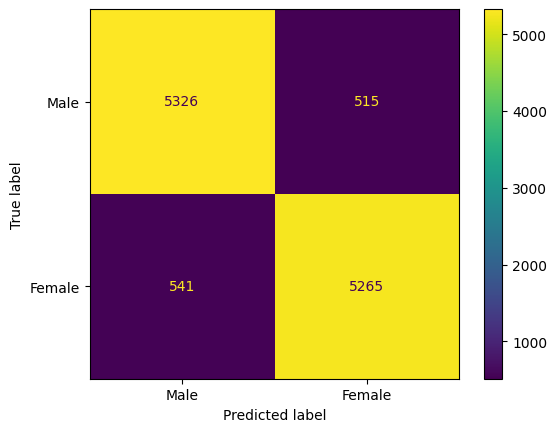

In [24]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [25]:
torch.save(model.state_dict(), 'vgg_revize_model.pth')

In [26]:
raise Exception("Eski Kod! Stop Here! Look at VGGTransferLearning.ipynb")

Exception: Eski Kod! Stop Here! Look at VGGTransferLearning.ipynb

## Inference

In [8]:
loaded_model = models.vgg16(pretrained=False)  # Load a new instance of VGG16
num_features = loaded_model.classifier[6].in_features
loaded_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
loaded_model.load_state_dict(torch.load('vgg_model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)  # Move the image to GPU if available

image_paths = ['harun.jpg', 'arda.jpg', 'fatmanur.jpg']  # Provide paths to the images
for image_path in image_paths:
    input_image = preprocess_image(image_path)
    with torch.no_grad():
        output = loaded_model(input_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        predicted_label = class_names[predicted_class]
        print(f"Image: {image_path}, Predicted Gender: {predicted_label}")

Image: harun.jpg, Predicted Gender: male
Image: arda.jpg, Predicted Gender: male
Image: fatmanur.jpg, Predicted Gender: female
